In [ ]:
!nvidia-smi

Sun Dec 25 18:36:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ML/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download Dogs-vs-Cats

 99% 801M/812M [00:04<00:00, 187MB/s]
100% 812M/812M [00:04<00:00, 207MB/s]


In [ ]:
!unzip Dogs-vs-Cats.zip

Archive:  Dogs-vs-Cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [ ]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import glob

In [ ]:
glob.glob("/content/train/*.jpg")[:5]

['/content/train/dog.11182.jpg',
 '/content/train/cat.11906.jpg',
 '/content/train/cat.8475.jpg',
 '/content/train/dog.11744.jpg',
 '/content/train/cat.3020.jpg']

In [ ]:
train_files = glob.glob('/content/train/*.jpg')
print(len(train_files))
labels = [os.path.basename(i).split('.')[0] for i in train_files]
#train_labels = [i.strip('/content/train/')[:3] for i in train_files]
train_df = pd.DataFrame({'filename': train_files, 'class': labels})
train_df.head()

25000


,filename,class
0,/content/train/dog.11182.jpg,dog
1,/content/train/cat.11906.jpg,cat
2,/content/train/cat.8475.jpg,cat
3,/content/train/dog.11744.jpg,dog
4,/content/train/cat.3020.jpg,cat


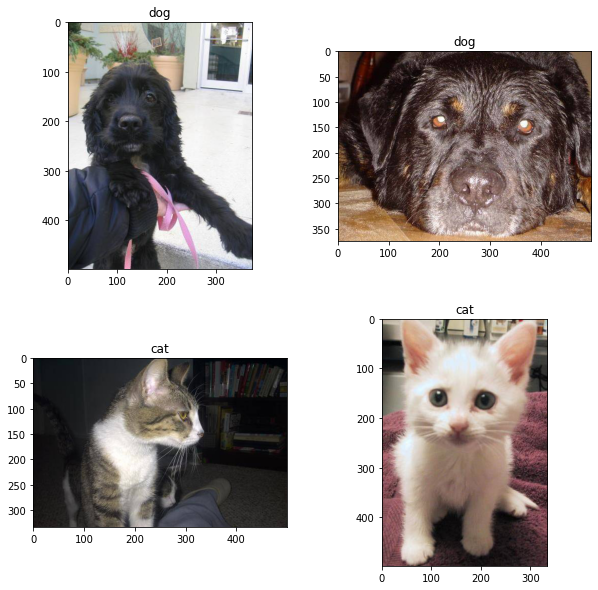

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# create a image data generator object. 
# all these are data augmentation parameters.

# now let's specify the image size to which each image will be resized to
img_height, img_width = 224, 224
batch_size = 64

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

# remember we put 0.2 validation split while defining ImageDataGenerator?
validation_generator = train_datagen.flow_from_dataframe(
    train_df, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

print("Class Indices:", train_generator.class_indices)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Class Indices: {'cat': 0, 'dog': 1}


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(img_width, img_height, 3)))
# 32 here means this layer will contain 32 filters of size 3x3 being learnt
model.add(BatchNormalization())
# batchnorm is a useful layer that helps in convergence
model.add(MaxPooling2D(pool_size=(2, 2)))
# maxpooling will reduce the size of the image
model.add(Dropout(0.25))
# dropout is used for regularization, ensuring that model doesn't overfit

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# convolutional block is complete. now on to defining the "head"

# first flatten the matrix to get a single array
model.add(Flatten())
# adding a dense hidden layer of neurons
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# finally the output layer with neurons=number of classes and softmax activation
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

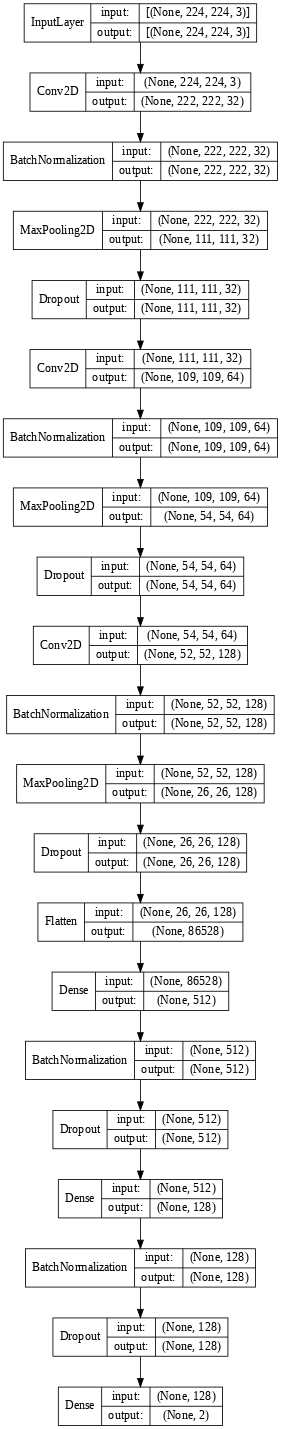

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/10
313/313 [==============================] - 318s 984ms/step - loss: 0.7915 - accuracy: 0.6100 - val_loss: 1.2042 - val_accuracy: 0.5060
Epoch 2/10
313/313 [==============================] - 304s 972ms/step - loss: 0.5833 - accuracy: 0.6877 - val_loss: 0.6852 - val_accuracy: 0.6376
Epoch 3/10
313/313 [==============================] - 306s 979ms/step - loss: 0.5288 - accuracy: 0.7326 - val_loss: 0.6295 - val_accuracy: 0.6756
Epoch 4/10
313/313 [==============================] - 305s 975ms/step - loss: 0.4868 - accuracy: 0.7615 - val_loss: 0.5223 - val_accuracy: 0.7400
Epoch 5/10
313/313 [==============================] - 303s 969ms/step - loss: 0.4461 - accuracy: 0.7878 - val_loss: 0.5012 - val_accuracy: 0.7456
Epoch 6/10
313/313 [==============================] - 303s 967ms/step - loss: 0.4216 - accuracy: 0.8048 - val_loss: 0.4702 - val_accuracy: 0.7862
Epoch 7/10
313/313 [==============================] - 302s 966ms/step - loss: 0.3868 - accuracy: 0.8258 - val_loss: 0.4962 -

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.save('catdogclassifier.h5')

In [ ]:
!unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [ ]:
test_files = glob.glob('/content/test1/*.jpg')
test_df = pd.DataFrame({'filename': test_files})
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [ ]:
preds = []

for X_batch in test_generator:
  for pic in X_batch:
    preds.append(model.predict(pic))    

InvalidArgumentError: ignored

2/2 [==============================] - 0s 23ms/step


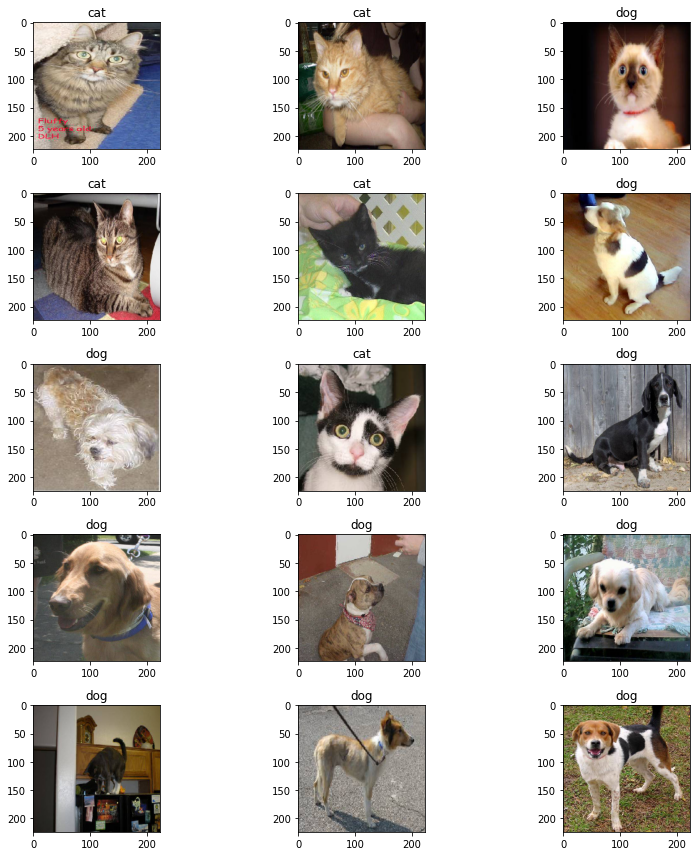

In [ ]:
def visualize_predictions(test_generator, model):
    plt.figure(figsize=(12, 12))
    for i in range(0, 15):
        plt.subplot(5, 3, i+1)
        for X_batch in test_generator:
            prediction = model.predict(X_batch)[0]
            image = X_batch[0]
            plt.imshow(image)
            plt.title('cat' if np.argmax(prediction)==0 else "dog")
            break
    plt.tight_layout()
    plt.show()
visualize_predictions(test_generator, model)

In [ ]:
myfiles = glob.glob('/content/drive/MyDrive/test01.jpg')
mydf = pd.DataFrame({'filename': myfiles})
mygen = ImageDataGenerator(rescale=1./255)

test_generator = mygen.flow_from_dataframe(
    mydf, x_col='filename', y_col=None, class_mode=None, target_size=(img_height, img_width), batch_size=1, shuffle=False)

for X_batch in test_generator:
  prediction = model.predict(X_batch)[0]
  image = X_batch[0]
  plt.imshow(image)
  plt.title('cat' if np.argmax(prediction)==0 else "dog")
  break
plt.show()

In [ ]:
testing = glob.glob('/content/test1/*.jpg')
testingdf = pd.DataFrame({'filename': testing})
testinggen = ImageDataGenerator(rescale=1./255)

testinggenerator = testinggen.flow_from_dataframe(
    testingdf,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=False)

preds = []

for X_batch in testinggenerator:
  prediction = model.predict(X_batch)[0]
  preds.append(np.argmax(prediction))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
